# B07.1 Hippocampal Annotaion  海马区中的差异基因

- Script Function: Perform regional segmentation of the sleep-deprived mouse brain based on Lasso results, generating results for each brain area.  
脚本功能：对组织中的海马区的细胞类型进行注释 
- Input: 1)  file 2）allen脑数据单细胞参考数据集  
输入：各样本海马区分割后的h5ad
- Output: gef files for each brain area  
输出：注释后的海马区h5ad

## 0. Package importing 环境导入

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/storeData/USER/data/05.Stomics_FAR/01.user/yiji/01.software/01.conda/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/storeData/USER/data/05.Stomics_FAR/01.user/yiji/01.software/01.conda/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/storeData/USER/data/05.Stomics_FAR/01.user/yiji/01.software/01.conda/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
import torch

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 1. Generate an Allen single cell annotation training model 生成allen单细胞注释训练模型

### 1.1 Define the reference dataset and perform preprocessing 定义参考数据集以及预处理

In [3]:
# reference (raw counts)
refdata = anndata.read_h5ad("./processdata/07.annotation/01.cell2loc/07.1.0.hippocamples_Allen_ref.h5ad")

# Calculate the number of cells for each donor_label, filter out the donor_labels with the number of cells greater than or equal to 10, and only retain the cells corresponding to the donor_labels with the number of cells greater than or equal to 10. 
# 计算每个donor_label的细胞数量,筛选出细胞数量大于或等于10的donor_label,仅保留细胞数量大于或等于10的donor_label对应的细胞
donor_label_counts = refdata.obs['donor_label'].value_counts()
donors_to_keep = donor_label_counts[donor_label_counts >= 10].index.tolist()
refdata = refdata[refdata.obs['donor_label'].isin(donors_to_keep)].copy()
refdata

AnnData object with n_obs × n_vars = 42851 × 17582
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'neurotransmitter_color', 'donor_label', 'dataset_label', 'batch', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'mt', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: '_scvi_extra_categorical_covs'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

Determine whether adata.var.index represents ENSEMBL ID or gene_symbol. In this tutorial, gene_symbol is used.   
请确定adata.var.index是ENSEMBL ID还是gene_symbol，本教程中使用gene_symbol

In [4]:
refdata.var['gene_id'] = refdata.var.index
refdata.var = refdata.var.set_index("gene_symbol")
refdata = refdata[:,~refdata.var.index.duplicated()]
refdata.var['mt'] = [varname.startswith('Mt-') for varname in refdata.var.index]
refdata.var

,mt,n_cells,nonz_mean,gene_id
gene_symbol,,,,
Xkr4,False,29507,21.241570,ENSMUSG00000051951
Gm1992,False,10671,1.573048,ENSMUSG00000089699
Gm19938,False,16724,2.130053,ENSMUSG00000102331
Rp1,False,632,1.226266,ENSMUSG00000025900
Sox17,False,2369,3.214014,ENSMUSG00000025902
...,...,...,...,...
CAAA01118383.1,False,8035,1.278905,ENSMUSG00000063897
Vamp7,False,16184,1.615237,ENSMUSG00000051412
Spry3,False,5836,1.274332,ENSMUSG00000061654


To preserve the representative genes of rare cell types, the cell2location developers recommend a cell_count_cutoff of 5. However, cell_percentage_cutoff2 and nonz_mean_cutoff can be adjusted to some extent for gene selection in the range of 8,000 - 16,000 genes.
In the 2D histogram below, the orange squares mark the genes that we need to exclude. The Y - axis represents the number of cells expressing the gene, and the X - axis represents the average total RNA amount of the cells in which the gene is located.  

为了保存稀有细胞类型的的代表基因，cell2location开发者推荐cell_count_cutoff=5，然而cell_percentage_cutoff2和nonz_mean_cutoff能够增加一些来在8k-16k基因的选择中进行选择。  
在下方的2D直方图中，橙色方块将我们需要排除的基因选择出来。Y轴代表了多少基因表达该基因，X轴代表该基因所在的细胞的RNA平均总量.

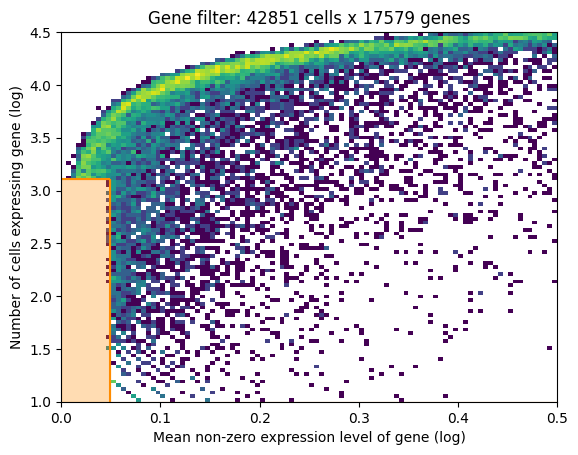

In [5]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(refdata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
refdata = refdata[:, selected].copy()
refdata.raw = refdata

### 1.2Train the model 训练模型

In [9]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=refdata,
                        # sample / batch
                        batch_key='donor_label',
                        # cell type, covariate used for constructing signatures
                        labels_key='subclass',
                        #multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['dataset_label']
                       )

In [10]:
from cell2location.models import RegressionModel
mod = RegressionModel(refdata)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'donor_label',
│   'labels_key': 'subclass',
│   'categorical_covariate_keys': ['dataset_label'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  168  │
│         n_cells          │ 42851 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  25   │
│          n_vars          │ 17579 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                              batch State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃          Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_label'] │  Gad2-IRES-Cre;Ai14-529270   │          0          │
│                          │  Gad2-IRES-Cre;Ai14-529271   │          1          │
│                          │  Gad2-IRES-Cre;Ai14-529272   │          2          │
│                          │  Gad2-IRES-Cre;Ai14-529273   │          3          │
│                          │ Snap25-IRES2-Cre;Ai14-372312 │          4          │
│                          │ Snap25-IRES2-Cre;Ai14-372317 │          5          │
│                          │ Snap25-IRES2-Cre;Ai14-374165 │          6          │
│                          │ Snap25-IRES2-Cre;Ai14-381917 │          7          │
│                          │ Snap25-IRES2-Cre;Ai14-426003 │          8          │
│                          │ Snap25-IRES2-Cre;Ai14-443005 │          9          │
│                          │ Snap25-IRES2-Cre;Ai14-443636 │         10          │
│                          │ Snap25-IRES2-Cre;Ai14-443644 │         11          │
│                          │ Snap25-IRES2-Cre;Ai14-450087 │         12          │
│                          │ Snap25-IRES2-Cre;Ai14-457909 │         13          │
│                          │ Snap25-IRES2-Cre;Ai14-457911 │         14          │
│                          │ Snap25-IRES2-Cre;Ai14-459490 │         15          │
│                          │ Snap25-IRES2-Cre;Ai14-459495 │         16          │
│                          │ Snap25-IRES2-Cre;Ai14-462434 │         17          │
│                          │ Snap25-IRES2-Cre;Ai14-463942 │         18          │
│                          │ Snap25-IRES2-Cre;Ai14-463943 │         19          │
│                          │ Snap25-IRES2-Cre;Ai14-464324 │         20          │
│                          │ Snap25-IRES2-Cre;Ai14-464327 │         21          │
│                          │ Snap25-IRES2-Cre;Ai14-464754 │         22          │
│                          │ Snap25-IRES2-Cre;Ai14-473980 │         23          │
│                          │ Snap25-IRES2-Cre;Ai14-473981 │         24          │
│                          │ Snap25-IRES2-Cre;Ai14-480185 │         25          │
│                          │ Snap25-IRES2-Cre;Ai14-482451 │         26          │
│                          │ Snap25-IRES2-Cre;Ai14-482452 │         27          │
│                          │ Snap25-IRES2-Cre;Ai14-482455 │         28          │
│                          │ Snap25-IRES2-Cre;Ai14-489429 │         29          │
│                          │ Snap25-IRES2-Cre;Ai14-490936 │         30          │
│                          │ Snap25-IRES2-Cre;Ai14-492080 │         31          │
│                          │ Snap25-IRES2-Cre;Ai14-492870 │         32          │
│                          │ Snap25-IRES2-Cre;Ai14-492874 │         33          │
│                          │ Snap25-IRES2-Cre;Ai14-493660 │         34          │
│                          │ Snap25-IRES2-Cre;Ai14-494813 │         35          │
│                          │ Snap25-IRES2-Cre;Ai14-498338 │         36          │
│                          │ Snap25-IRES2-Cre;Ai14-498911 │         37          │
│                          │ Snap25-IRES2-Cre;Ai14-499296 │         38          │
│                          │ Snap25-IRES2-Cre;Ai14-499298 │         39          │
│                          │ Snap25-IRES2-Cre;Ai14-500027 │         40          │
│                          │ Snap25-IRES2-Cre;Ai14-500199 │         41          │
│                          │ Snap25-IRES2-Cre;Ai14-504244 │         42          │
│                          │ Snap25-IRES2-Cre;Ai14-505064 │         43          │
│                          │ Snap25-IRES2-Cre;Ai14-505950 │     

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['subclass'] │     016 CA1-ProS Glut     │          0          │
│                       │       017 CA3 Glut        │          1          │
│                       │    025 CA2-FC-IG Glut     │          2          │
│                       │      036 HPF CR Glut      │          3          │
│                       │        037 DG Glut        │          4          │
│                       │     038 DG-PIR Ex IMN     │          5          │
│                       │       046 Vip Gaba        │          6          │
│                       │       047 Sncg Gaba       │          7          │
│                       │   048 RHP-COA Ndnf Gaba   │          8          │
│                       │      049 Lamp5 Gaba       │          9          │
│                       │    050 Lamp5 Lhx6 Gaba    │         10          │
│                       │ 051 Pvalb chandelier Gaba │         11          │
│                       │      052 Pvalb Gaba       │         12          │
│                       │       053 Sst Gaba        │         13          │
│                       │     145 MH Tac2 Glut      │         14          │
│                       │ 151 TH Prkcd Grin2c Glut  │         15          │
│                       │      318 Astro-NT NN      │         16          │
│                       │      319 Astro-TE NN      │         17          │
│                       │        326 OPC NN         │         18          │
│                       │       327 Oligo NN        │         19          │
│                       │        330 VLMC NN        │         20          │
│                       │        331 Peri NN        │         21          │
│                       │        332 SMC NN         │         22          │
│                       │        333 Endo NN        │         23          │
│                       │     334 Microglia NN      │         24          │
└───────────────────────┴───────────────────────────┴─────────────────────┘

              extra_categorical_covs State Registry              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location       ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset_label'] │ WMB-10Xv2  │          0          │
│                            │ WMB-10Xv3  │          1          │
│                            │            │                     │
└────────────────────────────┴────────────┴─────────────────────┘

In [11]:
import torch
torch.set_float32_matmul_precision('medium')

In [12]:
mod.train(max_epochs=300)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 300/300: 100%|██████████| 300/300 [29:17<00:00,  5.69s/it, v_num=1, elbo_train=6.23e+8]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [29:17<00:00,  5.86s/it, v_num=1, elbo_train=6.23e+8]


In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
refdata = mod.export_posterior(
    refdata, sample_kwargs={'num_samples': 1000, 'batch_size': 300,
                           }
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:26<00:00, 38.06it/s]


In [14]:
refdata

AnnData object with n_obs × n_vars = 42851 × 17579
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'neurotransmitter_color', 'donor_label', 'dataset_label', 'batch', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'n_cells', 'nonz_mean', 'gene_id'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: '_scvi_extra_categorical_covs'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

### 1.3  Generate model parameters 产出模型参数

In [15]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in refdata.varm.keys():
    inf_aver = refdata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in refdata.uns['mod']['factor_names']]].copy()
else:
    inf_aver = refdata.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in refdata.uns['mod']['factor_names']]].copy()
inf_aver.columns = refdata.uns['mod']['factor_names']
# 设置inf_aver的索引为adata_ref的var的GeneID-2
inf_aver.index = refdata.var.index
inf_aver.iloc[0:5, :]

,016 CA1-ProS Glut,017 CA3 Glut,025 CA2-FC-IG Glut,036 HPF CR Glut,037 DG Glut,038 DG-PIR Ex IMN,046 Vip Gaba,047 Sncg Gaba,048 RHP-COA Ndnf Gaba,049 Lamp5 Gaba,...,151 TH Prkcd Grin2c Glut,318 Astro-NT NN,319 Astro-TE NN,326 OPC NN,327 Oligo NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN
gene_symbol,,,,,,,,,,,,,,,,,,,,,
Xkr4,21.956512,24.120831,9.288478,3.152179,10.525273,5.625248,13.160422,17.757000,23.329847,24.687918,...,35.266918,0.215123,0.439618,2.548568,2.736554,0.556503,0.794931,0.559701,0.562882,0.342790
Gm1992,0.766508,0.967430,0.422394,0.126163,0.377607,0.198470,0.541254,0.718689,0.809448,0.949440,...,1.475424,0.006721,0.004541,0.081495,0.065329,0.021389,0.011692,0.023558,0.011704,0.004220
Gm19938,1.781300,2.209410,1.096522,0.259374,0.803349,0.478980,1.221880,1.456554,2.300856,2.368381,...,4.345135,0.031934,0.027308,0.311464,0.220134,0.037806,0.054751,0.061912,0.037928,0.011933
Rp1,0.022677,0.051342,0.032033,0.006359,0.006615,0.002167,0.008452,0.016117,0.008495,0.033954,...,0.036878,0.010981,0.000318,0.003795,0.003713,0.010895,0.003601,0.007031,0.155526,0.002560
Sox17,0.006770,0.020606,0.016093,0.010328,0.001830,0.006110,0.007154,0.020841,0.006166,0.022380,...,0.021869,0.012450,0.000903,0.002682,0.011652,0.008330,0.003347,0.005680,2.881070,0.001680


In [16]:
inf_aver_file = f"./processdata/07.annotation/01.cell2loc/Allenbrain_hippo_subclass_inf_aver.csv"
inf_aver.to_csv(inf_aver_file)

## 2.Annotation 注释

### 2.1 Read the data 读取数据.

In [37]:
data_path = './processdata/B05.Lasso/B05.CT1.Hippocampal.adjusted.cellbin.h5ad'
adata = sc.read_h5ad(data_path)
adata.obs['sample'] = 'CT1'

In [28]:
adata.var.index

Index(['Gnai3', 'Pbsn', 'Cdc45', 'H19', 'Scml2', 'Apoh', 'Narf', 'Cav2',
       'Klf6', 'Scmh1',
       ...
       'BX571804.1', 'AC124764.1', 'ETV3L', '1700094D03Rik', 'AC163638.2',
       'CAAA01077340.1', 'Shld3', 'AC135859.1', 'AC149091.1', 'Lim2'],
      dtype='object', length=28871)

In [29]:
# find mitochondria-encoded (MT) genes
adata.var['MT_gene'] = [gene.startswith('mt-') for gene in adata.var.index]
# remove MT genes for spatial mapping (keeping their counts in the object)
adata.obsm['MT'] = adata[:, adata.var['MT_gene'].values].X.toarray()
adata = adata[:, ~adata.var['MT_gene'].values]

### 2.2 Read the single cell feature list and re-integrate the spatially shared data 读取单细胞特征列表，重新整合空间共有数据

In [30]:
inf_aver_file = f"./processdata/07.annotation/01.cell2loc/Allenbrain_hippo_subclass_inf_aver.csv"
inf_aver = pd.read_csv(inf_aver_file, index_col=0)
inf_aver.head(5)

,016 CA1-ProS Glut,017 CA3 Glut,025 CA2-FC-IG Glut,036 HPF CR Glut,037 DG Glut,038 DG-PIR Ex IMN,046 Vip Gaba,047 Sncg Gaba,048 RHP-COA Ndnf Gaba,049 Lamp5 Gaba,...,151 TH Prkcd Grin2c Glut,318 Astro-NT NN,319 Astro-TE NN,326 OPC NN,327 Oligo NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN
gene_symbol,,,,,,,,,,,,,,,,,,,,,
Xkr4,21.956512,24.120830,9.288478,3.152179,10.525273,5.625248,13.160422,17.757000,23.329847,24.687918,...,35.266920,0.215123,0.439618,2.548568,2.736554,0.556503,0.794932,0.559701,0.562882,0.342790
Gm1992,0.766508,0.967430,0.422394,0.126163,0.377607,0.198470,0.541254,0.718689,0.809448,0.949440,...,1.475424,0.006721,0.004541,0.081495,0.065329,0.021389,0.011692,0.023558,0.011704,0.004220
Gm19938,1.781300,2.209410,1.096522,0.259374,0.803349,0.478980,1.221880,1.456554,2.300856,2.368381,...,4.345135,0.031934,0.027308,0.311464,0.220134,0.037806,0.054751,0.061912,0.037928,0.011933
Rp1,0.022677,0.051342,0.032033,0.006359,0.006615,0.002167,0.008452,0.016117,0.008495,0.033954,...,0.036878,0.010981,0.000318,0.003795,0.003713,0.010895,0.003601,0.007031,0.155526,0.002560
Sox17,0.006770,0.020606,0.016093,0.010328,0.001830,0.006110,0.007154,0.020841,0.006166,0.022380,...,0.021869,0.012450,0.000903,0.002682,0.011652,0.008330,0.003347,0.005680,2.881070,0.001680


Find the common genes, prepare the spatial adata, and find the common subset of adata and the reference markers.  

找到共有的基因，并且准备空间的adata，找到adata和参考标记的共同子集。

In [31]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata.var.index, inf_aver.index)
adata = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
duplicated_index = set(inf_aver.index[inf_aver.index.duplicated(keep=False)])
intersect = list(set(intersect).difference(duplicated_index))
adata = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [32]:
inf_aver

,016 CA1-ProS Glut,017 CA3 Glut,025 CA2-FC-IG Glut,036 HPF CR Glut,037 DG Glut,038 DG-PIR Ex IMN,046 Vip Gaba,047 Sncg Gaba,048 RHP-COA Ndnf Gaba,049 Lamp5 Gaba,...,151 TH Prkcd Grin2c Glut,318 Astro-NT NN,319 Astro-TE NN,326 OPC NN,327 Oligo NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN
gene_symbol,,,,,,,,,,,,,,,,,,,,,
Gm17102,0.395478,0.291505,0.273149,0.018992,0.109622,0.039596,0.118150,0.153306,0.121049,0.067047,...,0.224534,0.008525,0.002036,0.005228,0.002173,0.008708,0.006867,0.023137,0.001372,0.001719
Snx24,1.337895,2.532558,1.826028,0.412196,2.173098,0.601233,1.091449,2.578542,2.039126,1.376546,...,3.017022,0.437014,0.288531,0.532654,1.515005,0.469857,0.314414,0.208203,0.216331,1.774775
Trdmt1,0.211451,0.235789,0.210820,0.149380,0.156743,0.132413,0.284181,0.453935,0.538626,0.493164,...,0.276316,0.071411,0.068699,0.051015,0.151459,0.085551,0.036613,0.045389,0.074797,0.023605
Gabra5,10.901892,13.454442,13.524662,0.182903,3.400601,1.751074,0.263998,1.979026,2.355297,2.011178,...,0.599284,0.062298,0.080762,0.107590,0.028690,0.054263,0.104483,0.076459,0.061754,0.043266
Stoml2,1.203925,1.711982,2.060609,0.373393,0.504546,0.291141,0.896782,1.731087,1.774520,1.124867,...,1.930700,0.224551,0.188215,0.282641,0.323775,0.310459,0.110682,0.160945,0.203502,0.108098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Caskin2,0.022397,0.020764,0.017536,0.076979,0.009115,0.028625,0.021452,0.032069,0.063121,0.011841,...,0.016544,0.175834,0.192315,0.891182,0.405860,0.107610,0.115927,0.214518,0.825808,0.011965
Peli1,3.655510,3.162630,5.290173,0.568304,2.389131,1.504069,2.200368,2.773841,3.049380,2.339455,...,2.777959,0.573829,0.631756,1.573242,2.129039,0.730375,0.532395,0.636672,1.547469,1.309808
Ice1,2.544865,2.658280,2.580588,0.594923,1.419677,0.753520,1.555057,2.900148,2.318638,1.910365,...,2.980388,0.186386,0.291177,0.622365,0.767873,0.474182,0.319941,0.332994,0.434619,0.253848


### 2.3 Data splitting 数据分割

In [33]:
adata

AnnData object with n_obs × n_vars = 10538 × 17560
    obs: 'dnbCount', 'area', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'batch', 'sample'
    var: 'n_cells', 'n_counts', 'mean_umi', 'MT_gene'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial', 'MT'

### 2.4 Model Setup and Training 模型设置及训练

Anndata setup with scvi-tools version 1.3.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 10538 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 17560 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    CT1     │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 6000/6000: 100%|██████████| 6000/6000 [51:11<00:00,  1.96it/s, v_num=1, elbo_train=3.13e+7]

`Trainer.fit` stopped: `max_epochs=6000` reached.


Sampling global variables, sample: 100%|██████████| 999/999 [01:03<00:00, 15.80it/s]


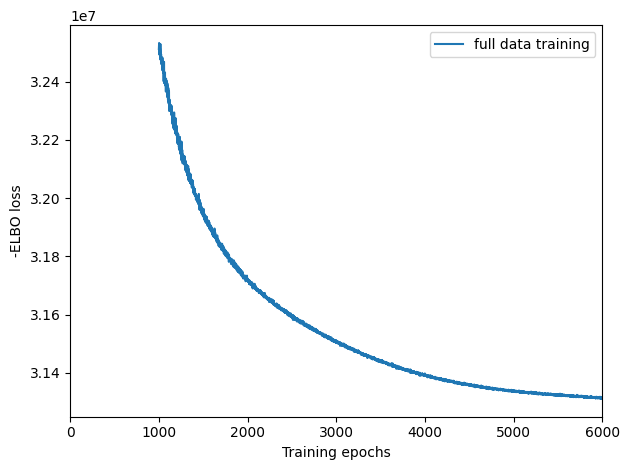

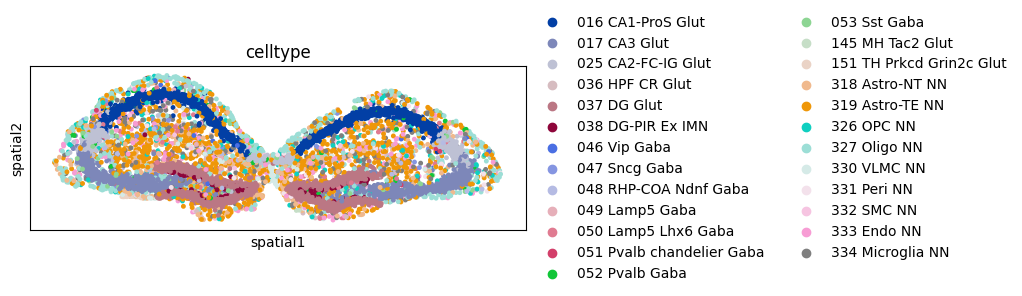

In [35]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata, batch_key="sample")
# create and train the model
mod = cell2location.models.Cell2location(
    adata, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1.2,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

mod.train(max_epochs=6000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

adata_st.obs[adata_st.uns['mod']['factor_names']] = adata_st.obsm['q05_cell_abundance_w_sf']
q05 = adata_st.obsm["q05_cell_abundance_w_sf"].copy(deep=True)
q05.columns = [i[23:]for i in adata_st.obsm["q95_cell_abundance_w_sf"].columns]
celltype = q05.idxmax(axis=1)
adata_st.obs['celltype'] = celltype
sc.pl.spatial(adata_st,spot_size=100,color="celltype")

In [38]:
adata_st

AnnData object with n_obs × n_vars = 10538 × 17560
    obs: 'dnbCount', 'area', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'batch', 'sample', '_indices', '_scvi_batch', '_scvi_labels', '016 CA1-ProS Glut', '017 CA3 Glut', '025 CA2-FC-IG Glut', '036 HPF CR Glut', '037 DG Glut', '038 DG-PIR Ex IMN', '046 Vip Gaba', '047 Sncg Gaba', '048 RHP-COA Ndnf Gaba', '049 Lamp5 Gaba', '050 Lamp5 Lhx6 Gaba', '051 Pvalb chandelier Gaba', '052 Pvalb Gaba', '053 Sst Gaba', '145 MH Tac2 Glut', '151 TH Prkcd Grin2c Glut', '318 Astro-NT NN', '319 Astro-TE NN', '326 OPC NN', '327 Oligo NN', '330 VLMC NN', '331 Peri NN', '332 SMC NN', '333 Endo NN', '334 Microglia NN', 'celltype'
    var: 'n_cells', 'n_counts', 'mean_umi', 'MT_gene'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn', '_scvi_uuid', '_scvi_manager_uuid', 'mod', 'celltype_colors'
    obsm: 'cell_border', 'spatial', 'MT', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_ce

In [39]:
adata

AnnData object with n_obs × n_vars = 10538 × 28871
    obs: 'dnbCount', 'area', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'batch', 'sample'
    var: 'n_cells', 'n_counts', 'mean_umi'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'

In [40]:
adata.obs= adata_st.obs

In [41]:
adata.write(f"./processdata/07.annotation/01.cell2loc/B07.CT1.Hippocampal.annotated.adjusted.cellbin.h5ad")